## High res ecco - Melville Bay

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import glob
import cartopy
import cartopy.crs as ccrs

#### Create netCDFs for theta and salt

In [2]:
ecco_melville_theta_dir = Path('H:/PhD_chap3/data/ECCO_melville/W_Greenland/THETA/')
ecco_melville_salt_dir = Path('H:/PhD_chap3/data/ECCO_melville/W_Greenland/SALT/')

In [3]:
theta_files = list(ecco_melville_theta_dir.glob('*nc'))
salt_files = list(ecco_melville_salt_dir.glob('*nc'))

In [4]:
## theta
theta_ds = xr.open_mfdataset(theta_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

In [5]:
## salt
salt_ds = xr.open_mfdataset(salt_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

Need to make a coordinate that combines year, month, and day

In [6]:
def create_time_dt64(ecco_ds):
    time_list = []
    for i in range(len(ecco_ds.time.values)):
        year  = ecco_ds.years.isel(time=i).values
        month = ecco_ds.months.isel(time=i).values
        day   = ecco_ds.days.isel(time=i).values
        
        if month<10 and day<10:
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+'0'+str(day)
        elif month<10 and day>=10: 
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+str(day)
        elif month>=10 and day<10: 
            time_tmp = str(year)+'-'+str(month)+'-'+'0'+str(day)
        else:
            time_tmp = str(year)+'-'+str(month)+'-'+str(day)
        
        time_list.append(time_tmp)
    
    time_dt64 = np.array(time_list, dtype='datetime64')
        
    return time_dt64

In [7]:
time_dt64 = create_time_dt64(theta_ds)

Add new time coordinate to dataset

In [8]:
theta_time_ds = theta_ds.assign_coords({"time":time_dt64})
salt_time_ds  = salt_ds.assign_coords({"time":time_dt64})

Pull out timestep to plot temp and salt

In [9]:
theta_400m = theta_time_ds.sel(time="2015-03").mean("time").sel(depth=400, method='nearest')
salt_400m  = salt_time_ds.sel(time="2015-03").mean("time").sel(depth=400, method='nearest')

In [10]:
## make land mask
land_mask = salt_time_ds.isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).SALT.isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

Save subsets

In [12]:
output_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
theta_400m.to_netcdf(output_dir + "theta_201503_400m.nc")
salt_400m.to_netcdf(output_dir + "salt_201503_400m.nc")
land_mask.to_netcdf(output_dir + "land_mask.nc")

Make subsets that include lat lon coordinates

In [13]:
theta_201503_400m = theta_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=400, method='nearest').THETA.sel(time="2015-03")
salt_201503_400m  = salt_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=400, method='nearest').SALT.sel(time="2015-03")

In [14]:
theta_201503_400m.to_netcdf(output_dir + "theta_201503_400m_latlon.nc")
salt_201503_400m.to_netcdf(output_dir + "salt_201503_400m_latlon.nc")

In [48]:
salt_201503 = salt_time_ds.sel(time="2015-03-01").isel(depth=0)

In [49]:
## make land mask
land_mask = salt_time_ds.set_coords(['longitude','latitude']).isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

In [55]:
land_mask.to_netcdf(output_dir + "land_mask_latlon.nc")

#### Plot model domain

Open subsets

In [56]:
theta_400m = xr.open_dataset(output_dir + "theta_201503_400m.nc")
salt_400m = xr.open_dataset(output_dir + "salt_201503_400m.nc")
land_mask = xr.open_dataset(output_dir + "land_mask.nc")

theta_201503_400m = xr.open_dataset(output_dir + "theta_201503_400m_latlon.nc")
salt_201503_400m = xr.open_dataset(output_dir + "salt_201503_400m_latlon.nc")
land_mask_latlon = xr.open_dataset(output_dir + "land_mask_latlon.nc")

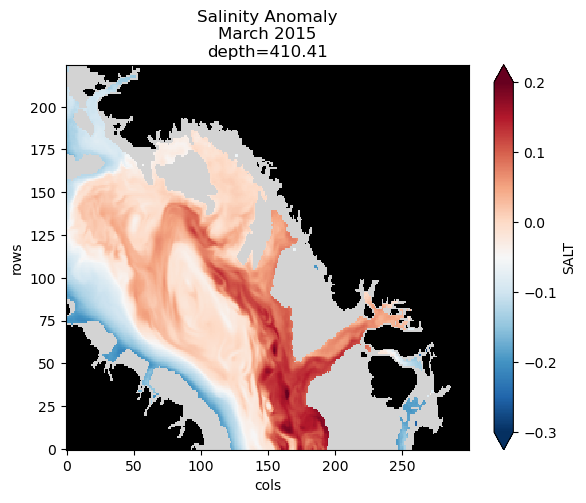

In [18]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

## salt below surface
salt_400m_below = salt_400m.SALT.where(salt_400m.SALT>30,drop=True)

(salt_400m_below-salt_400m_below.mean()).plot(ax=ax1,vmin=-0.3,vmax=0.2,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

ax1.set_title("Salinity Anomaly\nMarch 2015\ndepth=" + str(salt_400m.depth.values));

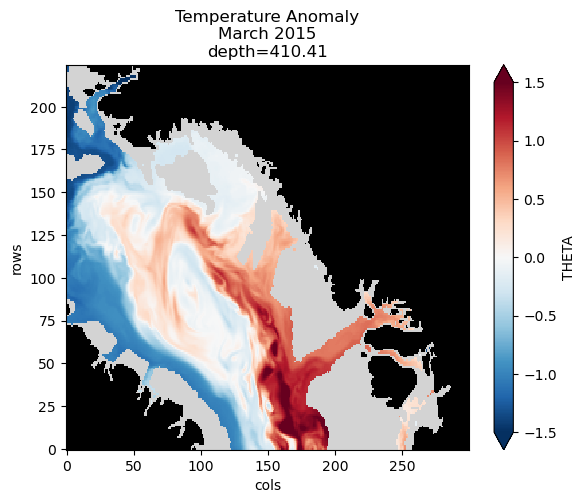

In [22]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

theta_400m_below = theta_400m.THETA.where(salt_400m.SALT>30,drop=True)

(theta_400m_below-theta_400m_below.mean()).plot(ax=ax1,vmin=-1.5,vmax=1.5,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

ax1.set_title("Temperature Anomaly\nMarch 2015\ndepth=" + str(theta_400m.depth.values));

#### Plot bathymetry over model domain

Load bathymetry data

In [24]:
gebco_bathy = xr.open_dataset("H:/PhD_chap3/data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc")

In [25]:
gebco_bathy_select = gebco_bathy.sel(lon=slice(-75,-56),lat=slice(69,76)).elevation.load()

In [68]:
salt_201503_400m_ts0 = salt_201503_400m.isel(time=0)
salt_400m_below = salt_201503_400m_ts0.SALT.where(salt_201503_400m_ts0.SALT>30,drop=True)

ABSOLUTE

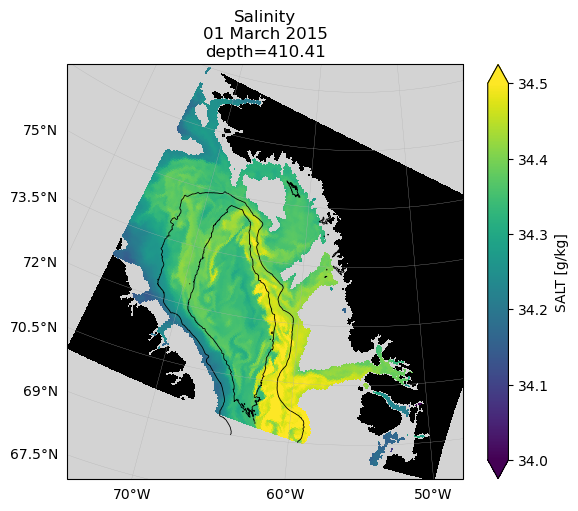

In [83]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=34,vmax=34.5,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

In [ ]:
theta_201503_400m_ts0 = theta_201503_400m.isel(time=0)
salt_201503_400m_ts0 = salt_201503_400m.isel(time=0)
theta_400m_below = theta_201503_400m_ts0.THETA.where(salt_201503_400m_ts0.SALT>30,drop=True)

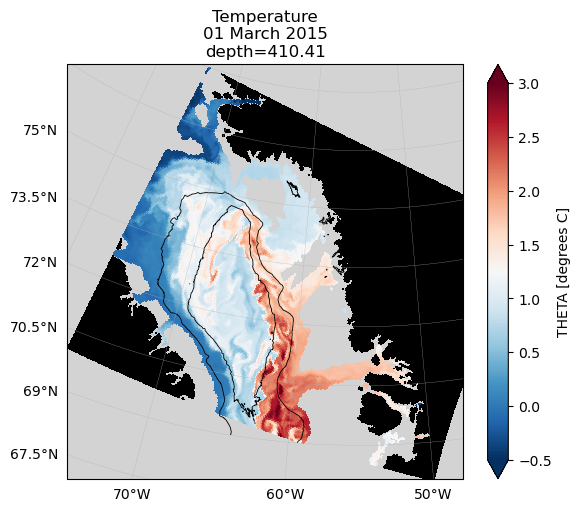

In [85]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

# theta_400m_below = theta_201503_400m.THETA.where(salt_201503_400m.SALT>30,drop=True)
# theta_400m_below.isel(time=0).plot(y='latitude',x='longitude',ax=ax1,transform=ccrs.PlateCarree())

theta_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

ANOMALY

In [74]:
salt_400m_below_anomaly = (salt_400m_below-salt_400m_below.mean()).load()

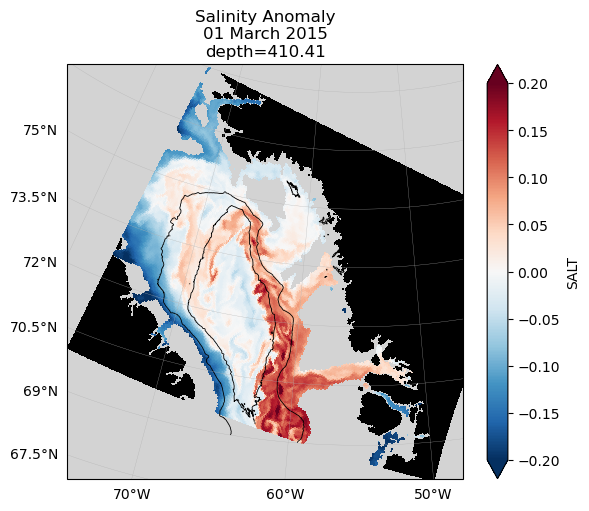

In [86]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below_anomaly.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.2,vmax=0.2,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity Anomaly\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

In [78]:
theta_400m_below_anomaly = (theta_400m_below-theta_400m_below.mean()).load()

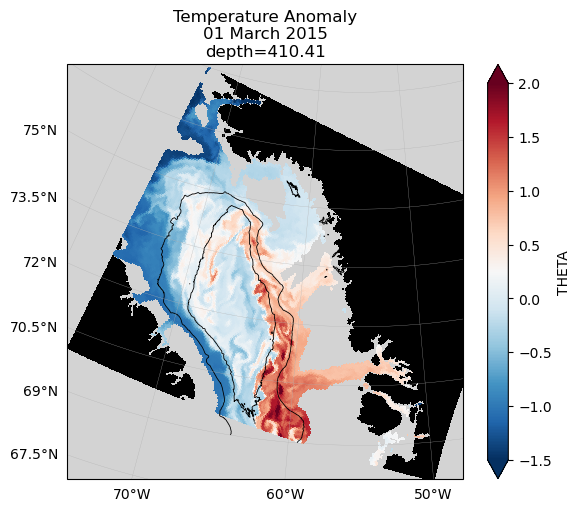

In [87]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

theta_400m_below_anomaly.plot(y='latitude',x='longitude',ax=ax1,vmin=-1.5,vmax=2,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature Anomaly\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

#### Take area-weighted mean

In [ ]:
## first switch latitude and longitude from variables to coordinates
theta_ds = theta_time_ds.set_coords(['latitude','longitude'])
salt_ds = salt_time_ds.set_coords(['latitude','longitude'])

In [ ]:
## select data for the three locations (all depths)

## Ummannaq (referred to as 'south')
south_theta_ds = theta_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).THETA
south_salt_ds  = salt_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).SALT

## Upernavik (referred to as 'center')
center_theta_ds = theta_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).THETA
center_salt_ds  = salt_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).SALT

## Melville Bay (referred to as 'north')
north_theta_ds = theta_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).THETA
north_salt_ds  = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).SALT

In [ ]:
south_theta_ds=south_theta_ds.load()

In [ ]:
south_theta_ds[:,0,0].plot()

In [ ]:
## take area weighted mean for each location
## cos(lat) is proportional to grid cell area
weights = np.cos(np.deg2rad(south_theta_ds.isel(time=0).latitude))
weights.name = 'weights_cosine_lat'

In [ ]:
## visualize weights - looks good (weights decrease with increasing latitude)
weights.plot();

In [ ]:
south_theta_mean_weighted = (south_theta_ds*weights).sum(dim=["rows","cols"])/weights.sum()

In [ ]:
# compare weighted and unweighted theta for Ummannaq
south_theta_mean_weighted.sel(depth=250, method='nearest').plot()
theta_time_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250, method='nearest').THETA.mean(['rows','cols']).plot(label='Ummannaq')

In [ ]:
## function to take area-weighted mean
def area_weighted_mean(ds):
    ## take area weighted mean for each location
    ## cos(lat) is proportional to grid cell area
    weights = np.cos(np.deg2rad(ds.isel(time=0).latitude))
    weights.name = 'weights_cosine_lat'
        
    ## take mean
    ds_mean_weighted = (ds*weights).sum(dim=["rows","cols"])/weights.sum()
    
    return ds_mean_weighted

In [ ]:
## take area-weighted mean for three locations

## Ummannaq (referred to as 'south')
south_theta_mean_weighted = area_weighted_mean(south_theta_ds)
south_salt_mean_weighted  = area_weighted_mean(south_salt_ds)

## Upernavik (referred to as 'center')
center_theta_mean_weighted = area_weighted_mean(center_theta_ds)
center_salt_mean_weighted  = area_weighted_mean(center_salt_ds)

## Melville Bay (referred to as 'north')
north_theta_mean_weighted = area_weighted_mean(north_theta_ds)
north_salt_mean_weighted  = area_weighted_mean(north_salt_ds)

#### Plot profiles of three regions

Melville Bay

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
north_theta_mean_weighted.plot(y='depth',cmap='RdYlBu_r',vmin=-2,vmax=3);
plt.ylim(1000,0);

In [ ]:
north_salt_mean_weighted.plot(y='depth',cmap='viridis',vmin=33,vmax=34.4);
plt.ylim(1000,0);

Upernavik

In [ ]:
center_theta_mean_weighted.plot(y='depth',cmap='RdYlBu_r',vmin=-2,vmax=3);
plt.ylim(1000,0);

In [ ]:
center_salt_mean_weighted.plot(y='depth',cmap='viridis',vmin=33,vmax=34.4);
plt.ylim(1000,0);

Ummannaq

In [ ]:
south_theta_mean_weighted.plot(y='depth',cmap='RdYlBu_r',vmin=-2,vmax=3);
plt.ylim(1000,0);

In [ ]:
south_salt_mean_weighted.plot(y='depth',cmap='viridis',vmin=33,vmax=34.4);
plt.ylim(1000,0);

#### Plot time series of three regions

In [ ]:
## select data for the three locations (250 m depth)

## Ummannaq (referred to as 'south')
south_theta_ds = theta_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').THETA
south_salt_ds  = salt_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').SALT

## Upernavik (referred to as 'center')
center_theta_ds = theta_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').THETA
center_salt_ds  = salt_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').SALT

## Melville Bay (referred to as 'north')
north_theta_ds = theta_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').THETA
north_salt_ds  = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').SALT

In [ ]:
## take area-weighted mean for three locations

## Ummannaq (referred to as 'south')
south_theta_mean_weighted = area_weighted_mean(south_theta_ds)
south_salt_mean_weighted  = area_weighted_mean(south_salt_ds)

## Upernavik (referred to as 'center')
center_theta_mean_weighted = area_weighted_mean(center_theta_ds)
center_salt_mean_weighted  = area_weighted_mean(center_salt_ds)

## Melville Bay (referred to as 'north')
north_theta_mean_weighted = area_weighted_mean(north_theta_ds)
north_salt_mean_weighted  = area_weighted_mean(north_salt_ds)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
north_theta_mean_250m.plot(label='Melville Bay')
center_theta_mean_250m.plot(label='Upernavik')
south_theta_mean_250m.plot(label='Ummannaq')
plt.ylabel("Theta (deg C)")
plt.legend()
plt.grid();

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
north_salt_mean_250m.plot(label='Melville Bay')
center_salt_mean_250m.plot(label='Upernavik')
south_salt_mean_250m.plot(label='Ummannaq')
plt.ylabel("Salinity")
plt.legend()
plt.grid();

This runs WAY faster

In [ ]:
# melville bay salinity
salt_ds_melville = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
salt_ds_melville.plot()

In [ ]:
# temperature
theta_ds_melville = theta_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).THETA
theta_ds_upernavik= theta_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).THETA
theta_ds_ummannaq = theta_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).THETA

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
theta_ds_melville.plot(label="melville")
theta_ds_upernavik.plot(label="upernavik")
theta_ds_ummannaq.plot(label="ummannaq")
plt.legend()
plt.grid();

In [ ]:
# salinity
salt_ds_melville = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT
salt_ds_upernavik= salt_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT
salt_ds_ummannaq = salt_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
salt_ds_melville.plot(label="melville")
salt_ds_upernavik.plot(label="upernavik")
salt_ds_ummannaq.plot(label="ummannaq")
plt.legend()
plt.grid();

Group data by month and plot

In [ ]:
north_theta_mean_12M  = north_theta_mean_250m.groupby("time.month").mean("time")
center_theta_mean_12M = center_theta_mean_250m.groupby("time.month").mean("time")
south_theta_mean_12M  = south_theta_mean_250m.groupby("time.month").mean("time")

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]
north_theta_mean_12M.plot(label='Melville Bay')
center_theta_mean_12M.plot(label='Upernavik')
south_theta_mean_12M.plot(label='Ummannaq')
plt.ylim(0.6,1.8)
plt.ylabel("Theta (deg C)")
plt.legend(loc='lower right')
plt.grid();

In [ ]:
north_salt_mean_12M  = north_salt_mean_250m.groupby("time.month").mean("time")
center_salt_mean_12M = center_salt_mean_250m.groupby("time.month").mean("time")
south_salt_mean_12M  = south_salt_mean_250m.groupby("time.month").mean("time")

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]
north_salt_mean_12M.plot(label='Melville Bay')
center_salt_mean_12M.plot(label='Upernavik')
south_salt_mean_12M.plot(label='Ummannaq')
plt.ylabel("Salinity")
plt.legend(loc='lower right')
plt.grid();

### Additional exploratory plots

In [ ]:
salt_tmp = salt_ds.isel(time=0)

In [ ]:
temp_ds_masked = theta_ds.THETA.where(salt_tmp.SALT>30)
salt_ds_masked = salt_ds.SALT.where(salt_tmp.SALT>30)

In [ ]:
plt.rcParams['figure.figsize'] = [11, 4]
fig, axs = plt.subplots(1,2)
ax1,ax2 = axs.ravel()
temp_ds_masked.sel(time='2016-07-01',depth=250,method='nearest').plot(ax=ax1)
salt_ds_masked.sel(time='2016-07-01',depth=250,method='nearest').plot(ax=ax2,vmin=33,vmax=34.4);

##### March

In [ ]:
plt.rcParams['figure.figsize'] = [7, 10]
plt.rcParams['font.size'] = '10'
fig, axs = plt.subplots(4,2,constrained_layout=True)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axs.ravel()

temp_min=-4
temp_max=4
salt_min=33
salt_max=34.4

temp_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax1,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax2,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax3,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax4,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax5,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax6,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax7,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax8,vmin=salt_min,vmax=salt_max);

labels=['2015','2015','2016','2016','2017','2017','2018','2018']
for ax,label in zip((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8),labels):
    ax.set_title(label)
    
    ## add rectangles to demarcate regions used in time series
    # Create a Rectangle patch
    rect_ummannaq  = patches.Rectangle((180-5, 50-5),  10, 10, linewidth=1, edgecolor='k', facecolor='none') # Ummannaq
    rect_upernavik = patches.Rectangle((145-5, 110-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Upernavik
    rect_melville  = patches.Rectangle((125-5, 150-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Melville Bay
    
    ax.add_patch(rect_ummannaq)
    ax.add_patch(rect_upernavik)
    ax.add_patch(rect_melville)

fig.suptitle("March")

##### December

In [ ]:
plt.rcParams['figure.figsize'] = [7, 10]
plt.rcParams['font.size'] = '10'
fig, axs = plt.subplots(4,2,constrained_layout=True)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axs.ravel()

temp_min=-4
temp_max=4
salt_min=33
salt_max=34.4

temp_ds_masked.sel(time='2015-12-01',depth=250,method='nearest').plot(ax=ax1,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2015-12-01',depth=250,method='nearest').plot(ax=ax2,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2016-12-01',depth=250,method='nearest').plot(ax=ax3,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2016-12-01',depth=250,method='nearest').plot(ax=ax4,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2017-12-01',depth=250,method='nearest').plot(ax=ax5,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2017-12-01',depth=250,method='nearest').plot(ax=ax6,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2018-12-01',depth=250,method='nearest').plot(ax=ax7,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2018-12-01',depth=250,method='nearest').plot(ax=ax8,vmin=salt_min,vmax=salt_max);

labels=['2015','2015','2016','2016','2017','2017','2018','2018']
for ax,label in zip((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8),labels):
    ax.set_title(label)
    
    ## add rectangles to demarcate regions used in time series
    # Create a Rectangle patch
    rect_ummannaq  = patches.Rectangle((180-5, 50-5),  10, 10, linewidth=1, edgecolor='k', facecolor='none') # Ummannaq
    rect_upernavik = patches.Rectangle((145-5, 110-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Upernavik
    rect_melville  = patches.Rectangle((125-5, 150-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Melville Bay
    
    ax.add_patch(rect_ummannaq)
    ax.add_patch(rect_upernavik)
    ax.add_patch(rect_melville)

fig.suptitle("December")

In [ ]:
plt.rcParams['figure.figsize'] = [11.5, 19]
fig, axs = plt.subplots(4,2)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axs.ravel()

temp_min=-4
temp_max=4
salt_min=33
salt_max=34.4

temp_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax1,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax2,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax3,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax4,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax5,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax6,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax7,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax8,vmin=salt_min,vmax=salt_max);

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ## add rectangles to demarcate regions used in time series
    # Create a Rectangle patch
    rect_ummannaq  = patches.Rectangle((180-5, 50-5),  10, 10, linewidth=1, edgecolor='k', facecolor='none') # Ummannaq
    rect_upernavik = patches.Rectangle((145-5, 110-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Upernavik
    rect_melville  = patches.Rectangle((125-5, 150-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Melville Bay
    
    ax.add_patch(rect_ummannaq)
    ax.add_patch(rect_upernavik)
    ax.add_patch(rect_melville)